In [1]:
%env CUDA_VISIBLE_DEVICES=4
%env TRANSFORMERS_CACHE=/mnt/LLM/hub
%env HF_HOME=/mnt/LLM/hub
%env OMP_NUM_THREADS=16

import os
import sys
sys.path.insert(0, '..')

import time
import random
from tqdm.auto import trange
import ipynbname  # pip install ipynbname
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

from src.aq import QuantizedWeight


torch.set_num_threads(16)
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_loading_dir = '/extra_disk_1/vahe1994/BRRR/layer10.self_attn.q_proj.input_activation.pt'  # <-- stealing from Vahe
num_codebooks = 1
nbits_per_codebook = 8
out_group_size = 1
in_group_size = 1
batch_size = 16384
beam_size = 1
beam_search_epochs = 100
print_frequency = 10
scale_nbits = 16    # 0 means no scales, 16 means no compression;
codebook_values_nbits = 16  # less than 16 means we quantize codebooks as well
init_max_iter = 100
entropy_regularizer = 1e-4
entropy_warmup_epochs = 0

scale_out_group_size = 1
scale_in_group_size = 8

env: CUDA_VISIBLE_DEVICES=4
env: TRANSFORMERS_CACHE=/mnt/LLM/hub
env: HF_HOME=/mnt/LLM/hub
env: OMP_NUM_THREADS=16


/home/jheuristic/anaconda3/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# import wandb

# os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), ipynbname.name() + ".ipynb")

# # start a new wandb run to track this script
# run = wandb.init(
#     # set the wandb project where this run will be logged
#     dir=os.getcwd(),
#     project="AddQuantization",
#     entity = "rock-and-roll",
#     save_code=True,
#     name = f"{ipynbname.name()}_AQ_{num_codebooks=}_{out_group_size=}_{in_group_size=}_{nbits_per_codebook=}_{beam_search_epochs=}",
#     settings=wandb.Settings(code_dir="."),
#     # track hyperparameters and run metadata
#     config={
#     "num_codebooks" : num_codebooks,
#     "out_group_size": out_group_size,
#     "in_group_size": in_group_size,
#     "group_size" : out_group_size * in_group_size,
#     "batch_size" : batch_size,
#     "beam_size" : beam_size,
#     "nbits_per_codebook" : nbits_per_codebook,
#     "codebook_values_nbits": codebook_values_nbits,
#     "scale_nbits": scale_nbits,
#     "beam_search_epochs": beam_search_epochs,
#     "init_max_iter": init_max_iter,
#     "entropy_regularizer": entropy_regularizer,
#     }
# )

In [3]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-70b-hf", torch_dtype='auto', low_cpu_mem_usage=True)

X = torch.load(input_loading_dir, map_location='cpu').float().flatten(0, -2)
reference_weight = model.model.layers[10].self_attn.q_proj.weight.detach().to(device).float()

XTX = torch.zeros(X.shape[-1], X.shape[-1], device=device, dtype=torch.float64)
for i in range(0, len(X), batch_size):
    x_batch = X[i: i + batch_size].cuda().double()
    XTX.addmm_(x_batch.T, x_batch, alpha=1/len(X))
    del x_batch
XTX = XTX.float()
del X

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
def _calculate_code_frequencies(codes: torch.LongTensor):
    code_counts = torch.zeros(num_codebooks, 2**nbits_per_codebook, dtype=torch.int64, device=codes.device)
    for codebook_index in range(num_codebooks):
        code_counts[codebook_index, :] = torch.bincount(
            codes[..., codebook_index].flatten(), minlength=2**nbits_per_codebook)
    return code_counts.float() / code_counts.sum(-1, keepdim=True)

def _calculate_code_entropy(codes: torch.LongTensor):
    """Calculate per-codebook code entropy measured in bits (base-2)"""
    probs = _calculate_code_frequencies(codes)
    logprobs = torch.log2(probs.clamp_min(1e-12))
    return - torch.sum(probs * logprobs, dim=-1)

def _get_entropy_penalties_upper_bound(codes: torch.LongTensor, regularizer: float):
    """Compute log-probability penalties that minimize a linearized upper bound on entropy """
    probs = _calculate_code_frequencies(codes)
    logprobs = torch.log2(probs.clamp_min(1e-12))
    return (- regularizer / logprobs.shape[-1]) * logprobs


# Main calibration code

initializing with kmeans:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jheuristic/AQLM_entropy/notebooks/../src/aq.py:712: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/aten/src/ATen/native/cuda/Indexing.cu:1193.)
  codebook_i, _, _ = fit_kmeans(


AVG bits: 10.00006103515625
loss=0.0001479201	 time_on_epoch 0 = 1.6198592851869762
loss=0.0000322315	 time_on_epoch 10 = 0.2393367807380855
loss=0.0000144200	 time_on_epoch 20 = 0.23888144083321095
loss=0.0000096756	 time_on_epoch 30 = 0.23954172059893608
loss=0.0000076944	 time_on_epoch 40 = 0.23961295187473297
loss=0.0000065733	 time_on_epoch 50 = 0.23913319315761328
loss=0.0000058036	 time_on_epoch 60 = 0.2390828221105039
loss=0.0000052188	 time_on_epoch 70 = 0.23844718327745795
loss=0.0000047565	 time_on_epoch 80 = 0.2386475638486445
loss=0.0000043968	 time_on_epoch 90 = 0.23945542285218835
Entropy before beam search: tensor([7.9636], device='cuda:0')


  0%|          | 0/8192 [00:00<?, ?it/s]

Entropy after beam search: tensor([5.2576], device='cuda:0')


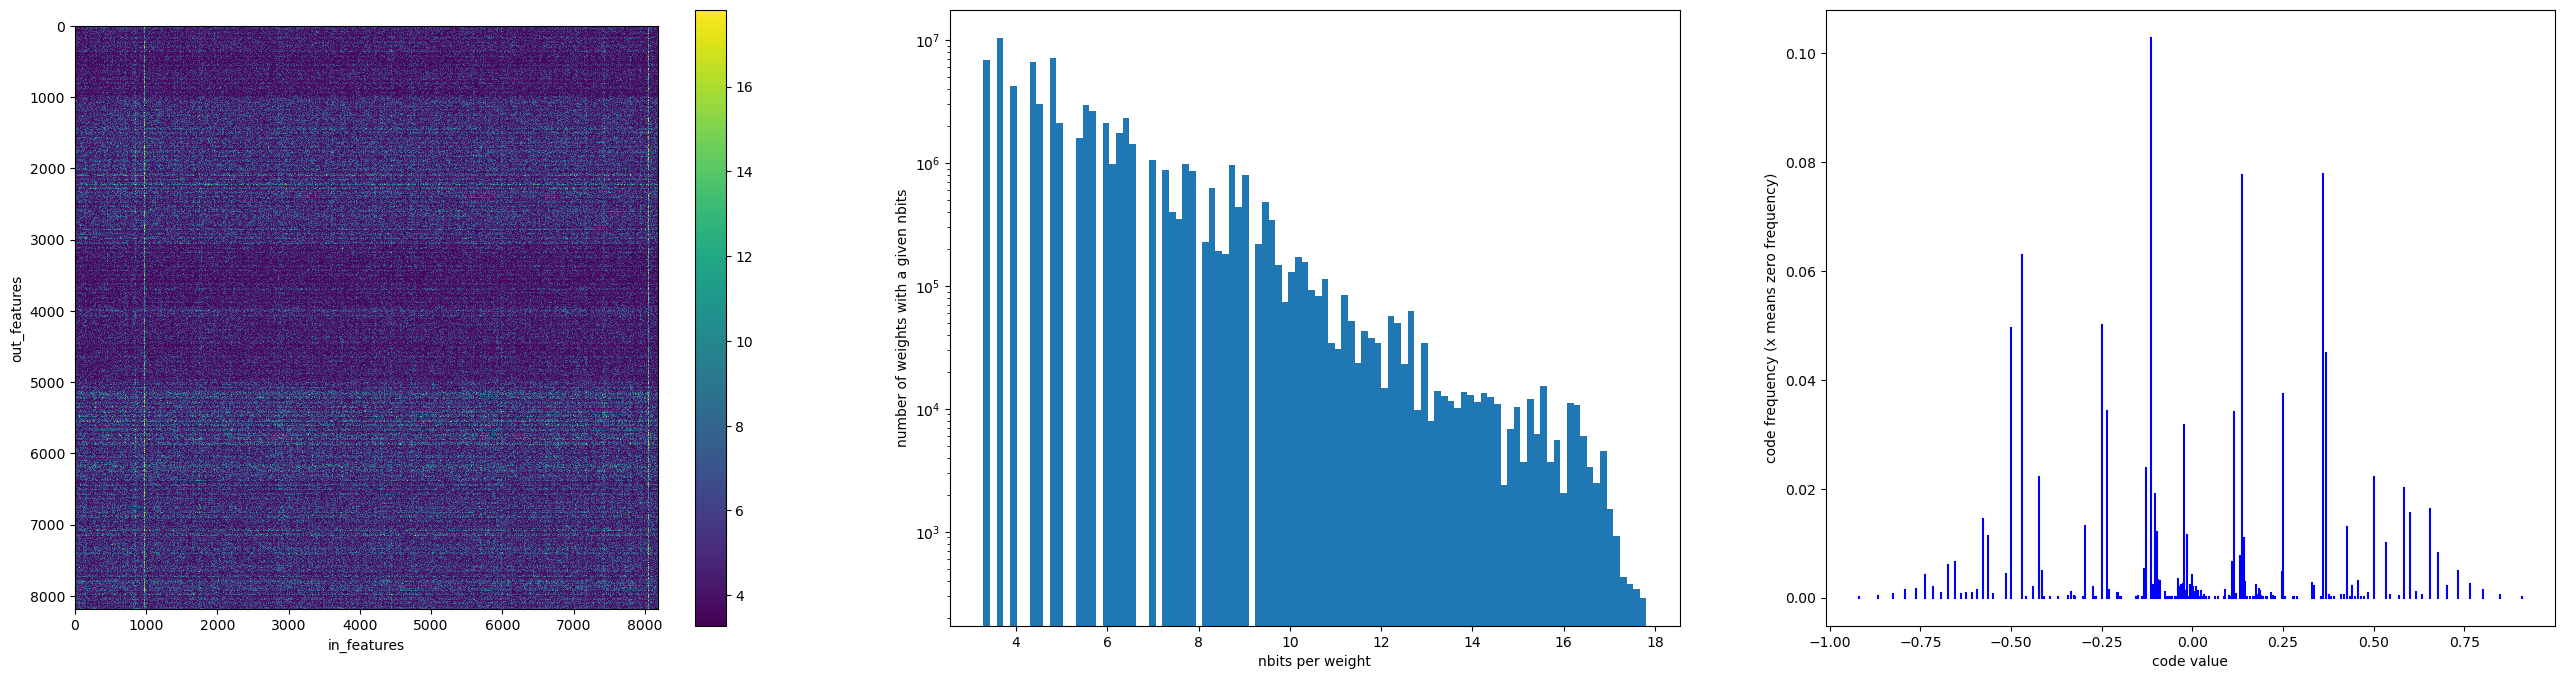

loss=0.0001711874	 time_on_epoch 100 = 0.2670219140127301
loss=0.0001507386	 time_on_epoch 110 = 0.3024184280075133
loss=0.0001407854	 time_on_epoch 120 = 0.302495988085866
loss=0.0001340910	 time_on_epoch 130 = 0.3018885883502662
loss=0.0001290707	 time_on_epoch 140 = 0.3018889375962317
loss=0.0001251099	 time_on_epoch 150 = 0.30247506871819496
loss=0.0001218718	 time_on_epoch 160 = 0.30207255808636546
loss=0.0001192003	 time_on_epoch 170 = 0.30200138920918107
loss=0.0001169543	 time_on_epoch 180 = 0.30164771899580956
loss=0.0001149774	 time_on_epoch 190 = 0.3015222796238959
Entropy before beam search: tensor([5.2576], device='cuda:0')


  0%|          | 0/8192 [00:00<?, ?it/s]

Entropy after beam search: tensor([2.9441], device='cuda:0')


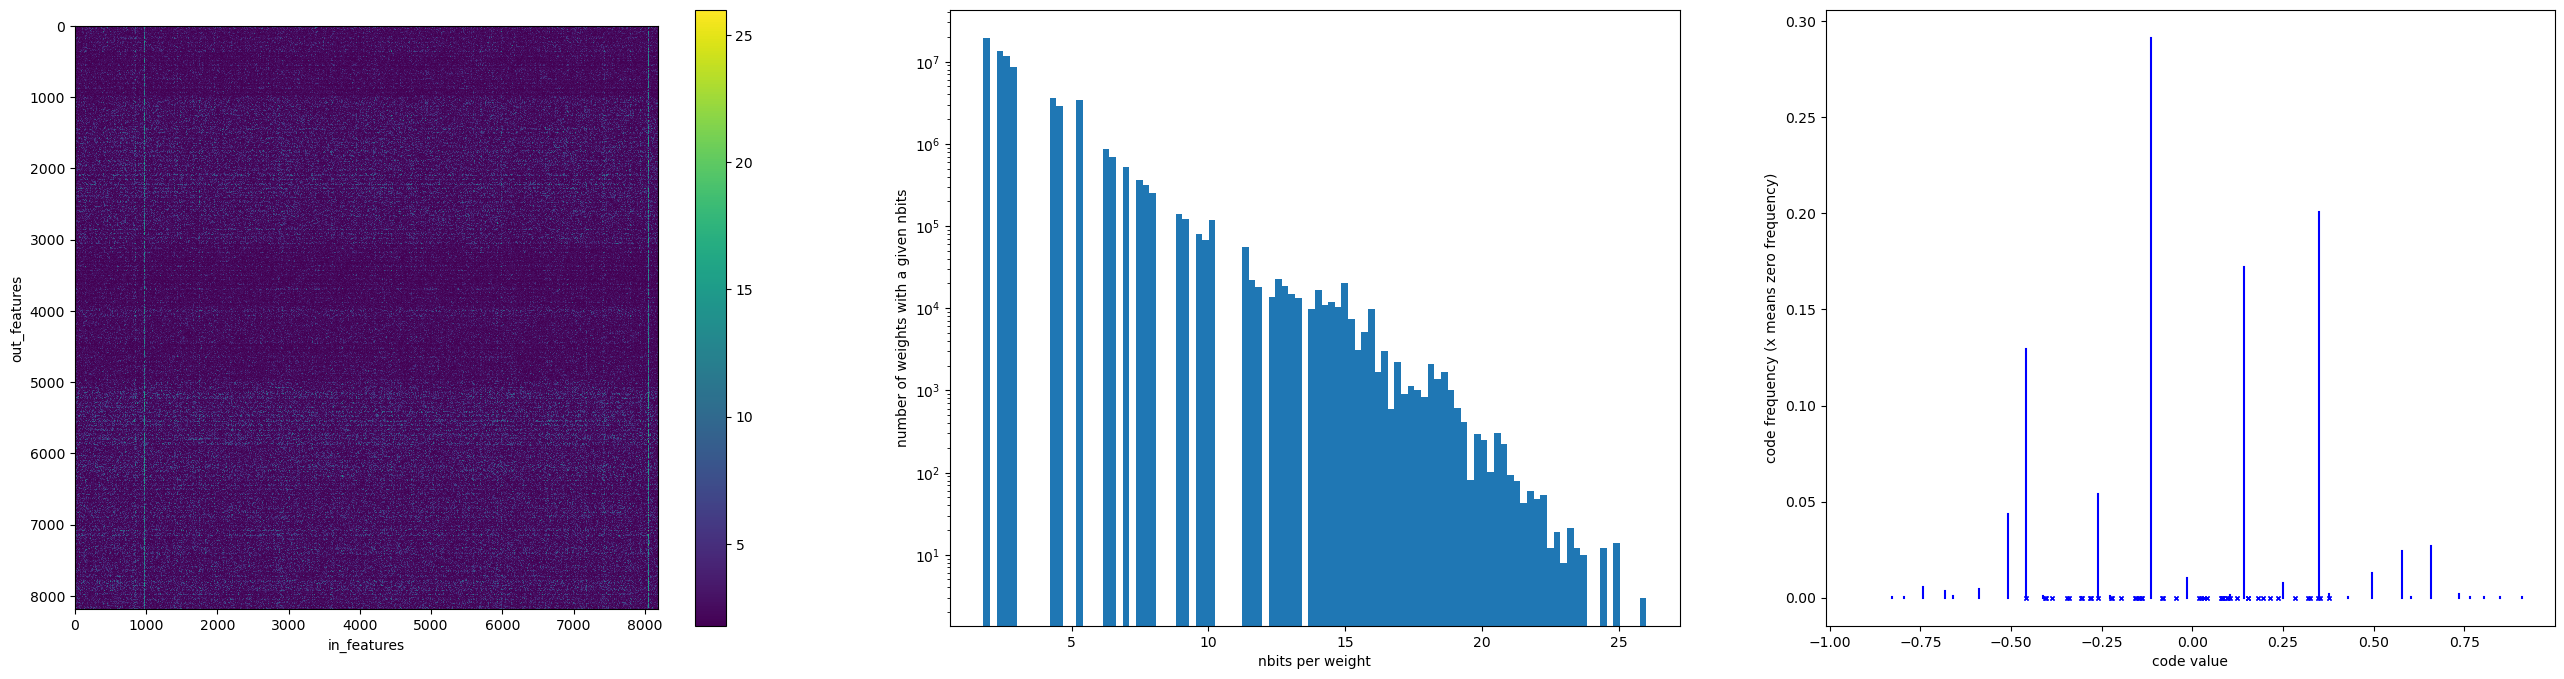

loss=0.0007453182	 time_on_epoch 200 = 0.3221220336854458
loss=0.0006923885	 time_on_epoch 210 = 0.42802016204223037
loss=0.0006667970	 time_on_epoch 220 = 0.4287064909003675
loss=0.0006498704	 time_on_epoch 230 = 0.42796285171061754
loss=0.0006376860	 time_on_epoch 240 = 0.4288519718684256
loss=0.0006285054	 time_on_epoch 250 = 0.4285063333809376
loss=0.0006213513	 time_on_epoch 260 = 0.4283551718108356
loss=0.0006156216	 time_on_epoch 270 = 0.4280074122361839
loss=0.0006109276	 time_on_epoch 280 = 0.4288744628429413
loss=0.0006070089	 time_on_epoch 290 = 0.4281805632635951
Entropy before beam search: tensor([2.9441], device='cuda:0')


  0%|          | 0/8192 [00:00<?, ?it/s]

Entropy after beam search: tensor([2.4594], device='cuda:0')


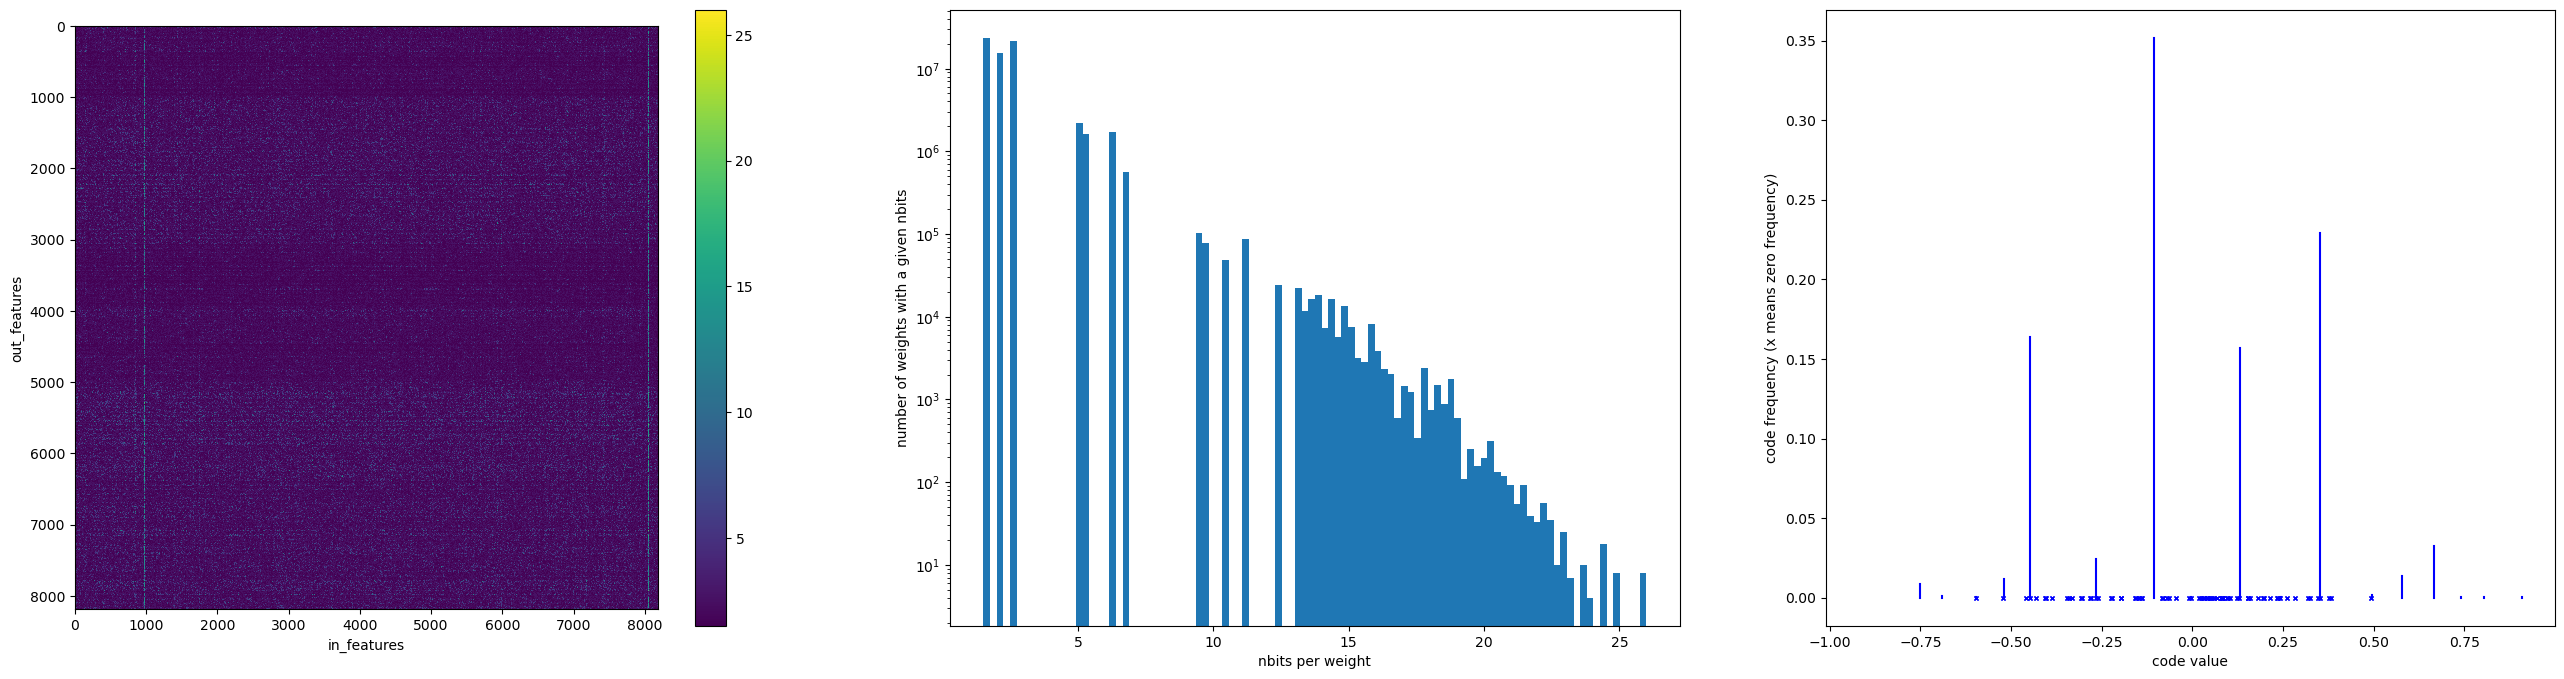

loss=0.0010544373	 time_on_epoch 300 = 0.3423135383054614
loss=0.0010060938	 time_on_epoch 310 = 0.4718033540993929
loss=0.0009830270	 time_on_epoch 320 = 0.47189376363530755
loss=0.0009678380	 time_on_epoch 330 = 0.47176919505000114


In [ ]:
quantized_weight = QuantizedWeight(
    XTX=XTX, reference_weight=reference_weight, num_codebooks=num_codebooks,
    nbits_per_codebook=nbits_per_codebook, scale_nbits=scale_nbits, 
    out_group_size=out_group_size, in_group_size=in_group_size,
    verbose=True, max_iter=init_max_iter,   # faster init, not tested
    scale_out_group_size=scale_out_group_size, scale_in_group_size=scale_in_group_size
)
# run.log({"Avg_bits": quantized_weight.estimate_nbits_per_parameter()})
print("AVG bits:", quantized_weight.estimate_nbits_per_parameter())
opt = torch.optim.Adam(quantized_weight.parameters(), lr=1e-4, betas=(0.0, 0.95), amsgrad=True)


for epoch in range(1000):
    start = time.perf_counter()
    delta_weight = (quantized_weight() - reference_weight).double()
    loss = (delta_weight @ XTX.double()).flatten() @ delta_weight.flatten() / len(delta_weight)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    #run.log({'loss':loss.item()}, step=epoch)
    
    if epoch % print_frequency == 0:
        print(f"loss={loss.item():.10f}\t",
              f"time_on_epoch {epoch} = {time.perf_counter() - start}")
    if (epoch + 1) % beam_search_epochs == 0:
        print("Entropy before beam search:", _calculate_code_entropy(quantized_weight.codes))
        code_penalties = _get_entropy_penalties_upper_bound(quantized_weight.codes, regularizer=entropy_regularizer)
        if epoch < entropy_warmup_epochs:   # hypothesis: this could help last codebooks become more meaningful before we prune them via entropy regularizer
            code_penalties *= 0
            print("Not regularizing for epoch", epoch)
        quantized_weight.beam_search_update_codes_(
            XTX, reference_weight, beam_size=beam_size, code_penalties=code_penalties,
            dim_rng=random.Random(), verbose=True)
        current_entropy = _calculate_code_entropy(quantized_weight.codes)
        print("Entropy after beam search:", current_entropy)
        
        
        
        freqs = _calculate_code_frequencies(quantized_weight.codes).flatten()
        code_nbits = -torch.log2(freqs.clamp_min(1e-18))
        weight_nbits = code_nbits[quantized_weight.codes].reshape(*reference_weight.shape).cpu().numpy()
        plt.figure(figsize=(32, 8))
        plt.title(f"Codes with entropy = {current_entropy:.5f}")
        plt.subplot(131)
        plt.imshow(weight_nbits, interpolation='none')
        plt.xlabel("in_features")
        plt.ylabel("out_features")
        plt.colorbar()
        plt.subplot(132)
        plt.hist(weight_nbits.ravel(), bins=100);
        plt.yscale('log')
        plt.xlabel('nbits per weight')
        plt.ylabel('number of weights with a given nbits')
        plt.subplot(133)
        code_values = quantized_weight.codebooks.detach().cpu().numpy().ravel()
        code_freqs = freqs.cpu().numpy()
        for i in range(len(code_freqs)):
            plt.plot([code_values[i]] * 2, [0, code_freqs[i]], color='blue', 
                     marker='' if code_freqs[i] > 0 else 'x', markersize=3)
        plt.xlabel("code value")
        plt.ylabel("code frequency (x means zero frequency)")
        plt.savefig("weight_nbits.pdf")
        plt.show()

#         if code_penalties is not None:
#             mean_code_nbits = sum(get_mean_nbits_by_codebook(quantized_weight.codes)) / num_codebooks
#             print(f"mean_code_nbits {mean_code_nbits:.5f}")
#             run.log({'Mean codebook length nbits': mean_code_nbits}, step=epoch)
#             if in_group_size > 1 and out_group_size > 1:
#                 curr_avg_bits  = calc_avg_bits(num_codebooks, 1, mean_code_nbits,
#                                      nbits_per_codebook, in_features, out_features, scale_nbits)
#                 run.log({"Avg_bits": curr_avg_bits}, step=epoch)